In [1]:
# Dataset Loading and Analysis for Drywall QA Prompted Segmentation

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
from load import get_dataset_files
import torch.nn.functional as F
from dataset import create_combined_dataset, DryWallQADataset
from visualize import visualize_samples, detailed_sample_analysis, get_sample_indices, visualize_preds_and_masks
from train import setup_model, setup_data_loaders, collate_fn, configure_trainable_parameters, get_training_config, train_one_epoch, evaluate

# Set up paths
BASE_DIR = Path("/Users/prashanthreddyduggirala/10x")
CRACKS_DATASET = BASE_DIR / "cracks.v1i.voc"
DRYWALL_DATASET = BASE_DIR / "Drywall-Join-Detect.v1i.voc"

print("Imports successful!")

DryWallQADataset class defined!
create_combined_dataset function defined!

Dataset features:
- Handles both polygon (crack) and bounding box (drywall) annotations
- Multiple text prompts per category for data augmentation
- Creates binary masks for CLIPSeg training


/Users/prashanthreddyduggirala/10x/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports successful!


In [2]:
# Load both datasets
print("Loading crack detection dataset...")
cracks_files = get_dataset_files(CRACKS_DATASET)

print("Loading drywall joint detection dataset...")
drywall_files = get_dataset_files(DRYWALL_DATASET)

Loading crack detection dataset...
Loading drywall joint detection dataset...


In [3]:
# Create the combined dataset
print("Creating combined dataset...")
train_images, train_annotations, train_prompts, train_labels = create_combined_dataset(['train'], cracks_files, drywall_files)
val_images, val_annotations, val_prompts, val_labels = create_combined_dataset(['valid'], cracks_files, drywall_files)

print(f"Combined datasets created!")
print(f"   Total train samples: {len(train_images)}")
print(f"   Total validation samples: {len(val_images)}")


train_crack_count = train_labels.count('crack')
train_drywall_count = train_labels.count('drywall_joint')
val_crack_count = val_labels.count('crack')
val_drywall_count = val_labels.count('drywall_joint')


# Create dataset instance
train_dataset = DryWallQADataset(train_images, train_annotations, train_prompts)
print(f"\nTrain Dataset instance created with {len(train_dataset)} samples")

val_dataset = DryWallQADataset(val_images, val_annotations, val_prompts)
print(f"Validation Dataset instance created with {len(val_dataset)} samples")


Creating combined dataset...
Combined datasets created!
   Total train samples: 5984
   Total validation samples: 403

Train Dataset instance created with 5984 samples
Validation Dataset instance created with 403 samples


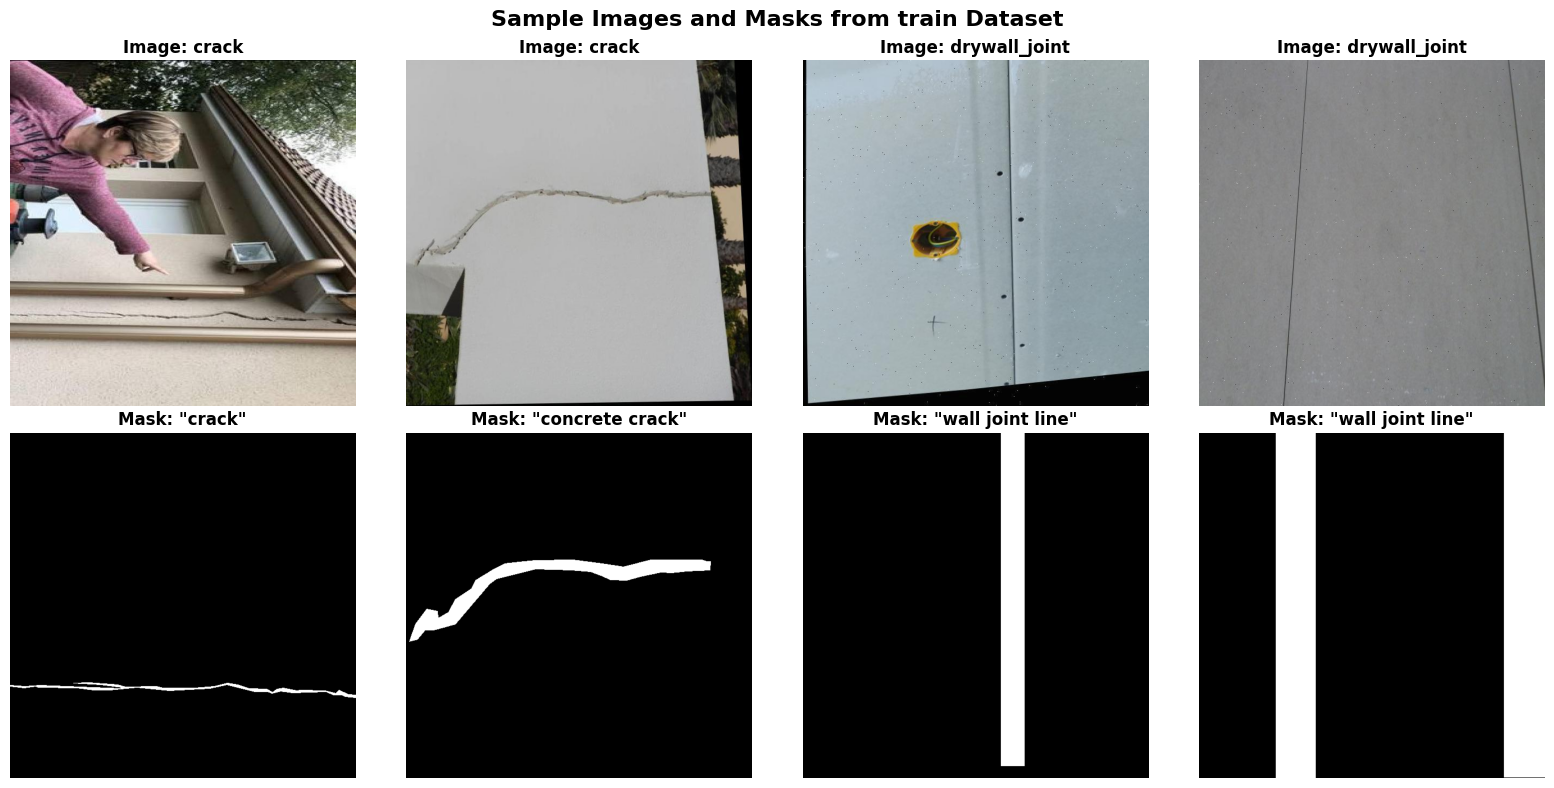

🔍 DETAILED SAMPLE ANALYSIS:

Sample 1 (crack):
  Text prompt: 'crack'
  Mask coverage: 0.81% of image
  Mask pixels: 3,316 / 409,600
  Filename: cracking0153_jpg.rf.d6b2c089a3280d0cd62a67a27dd18ba6.jpg

Sample 2 (crack):
  Text prompt: 'concrete crack'
  Mask coverage: 3.44% of image
  Mask pixels: 14,097 / 409,600
  Filename: crack277_jpg.rf.15e994d62ce8bdf48d816c1fe9016975.jpg

Sample 3 (drywall_joint):
  Text prompt: 'wall joint line'
  Mask coverage: 6.63% of image
  Mask pixels: 27,148 / 409,600
  Filename: IMG_20220627_111635-jpg_1500x2000_jpg.rf.47e5091ac61f1763481557f905115371.jpg

Sample 4 (drywall_joint):
  Text prompt: 'wall joint line'
  Mask coverage: 23.38% of image
  Mask pixels: 95,774 / 409,600
  Filename: 2000x1500_68_resized_jpg.rf.2d4a90cbfd15f0642aecf368019cffa1.jpg


In [4]:
sample_indices = get_sample_indices(train_labels)
visualize_samples(train_dataset, train_labels, sample_indices)
detailed_sample_analysis(train_dataset, train_labels, sample_indices)

In [19]:
model, processor, device = setup_model(checkpoint_path="/Users/prashanthreddyduggirala/10x/notebooks/base_clipseg_drywall_model.pth")

SETTING UP CLIPSEG MODEL
Loading checkpoint from: /Users/prashanthreddyduggirala/10x/notebooks/base_clipseg_drywall_model.pth
Checkpoint loaded successfully!
   Epoch: 1
   Validation Loss: 0.1785
   Training Loss: 0.1173
Model loaded and moved to: cpu


In [6]:
encoder_params_list, decoder_params_list = configure_trainable_parameters(model)

CONFIGURING TRAINABLE PARAMETERS
Trainable parameters: 150,747,746 / 150,747,746 (100.0%)


In [7]:
config = get_training_config(
    batch_size=16,
    encoder_lr=1e-6,
    decoder_lr=1e-4,
    num_epochs=10,
    save_every=None,
    eval_every=170,
    optim_weight_decay=1e-5,
    checkpoint_base_path="/Users/prashanthreddyduggirala/10x/checkpoints/"
)

🔧 TRAINING CONFIGURATION
Batch size: 16
Learning rate: 1e-06
Number of epochs: 10
Save frequency: Only best model at epoch end
Eval frequency: Every 170 steps
Eval configuration: 170


In [8]:
train_loader, val_loader = setup_data_loaders(train_dataset, val_dataset, processor, config)

SETTING UP DATA LOADERS
Batch size: 16
Data loaders created:
   Train batches: 374
   Validation batches: 26
   Samples per epoch: 5984


In [ ]:
import time
from torch.nn import BCEWithLogitsLoss

# Fixed Main Training Loop
print("STARTING CLIPSEG TRAINING")
print("=" * 50)

optimizer = torch.optim.AdamW([
    # Now this list comprehension works because we use the *list* version
    {'params': encoder_params_list, 'lr': config['encoder_lr']},
    {'params': decoder_params_list, 'lr': config['decoder_lr']}
],
# Apply global weight decay
weight_decay=config.get('optim_weight_decay')
)
criterion = BCEWithLogitsLoss()

# Training history
train_losses = []
val_losses = []
best_val_loss = float('inf')

print(f"Training Details:")
print(f"   Optimizer: AdamW (encoder lr={config['encoder_lr']}, decoder lr={config['decoder_lr']})")
print(f"   Loss function: BCEWithLogitsLoss")
print(f"   Device: {device}")
print(f"   Model input: 640x640 -> 352x352 (internal)")
print(f"   Model output: 352x352 -> 640x640 (upsampled)")

# Start training
start_time = time.time()

for epoch in range(config['num_epochs']):
    print(f"\nEpoch {epoch+1}/{config['num_epochs']}")
    print("-" * 30)
    
    # Train for one epoch
    epoch_start = time.time()
    train_loss = train_one_epoch(
        model, 
        train_loader, 
        optimizer, 
        criterion, 
        device, 
        epoch, 
        save_every=config.get('save_every'),
        eval_every=config.get('eval_every'),
        val_loader=val_loader,
        checkpoint_path_prefix=config.get('checkpoint_base_path') + "clipseg_drywall_model", 
    )
    
    # Evaluate on validation set
    val_loss = evaluate(model, val_loader, criterion, device)
    
    # Record losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Calculate epoch time
    epoch_time = time.time() - epoch_start
    
    # Print epoch results
    print(f"Epoch {epoch+1} completed in {epoch_time:.1f}s")
    print(f"   Train Loss: {train_loss:.4f}")
    print(f"   Val Loss: {val_loss:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"🏆 New best validation loss: {val_loss:.4f}")
        # Save model checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }
        torch.save(checkpoint, config['checkpoint_base_path'] + 'clipseg_drywall_model' + f"_{epoch}.pth")
        print(f"Model saved as 'clipseg_drywall_model_{epoch}.pth'")

In [9]:
test_images, test_annotations, test_prompts, test_labels = create_combined_dataset(['test'], cracks_files, drywall_files)
test_dataset = DryWallQADataset(test_images, test_annotations, test_prompts)
print(f"Test Dataset instance created with {len(test_dataset)} samples")

Test Dataset instance created with 4 samples


/Users/prashanthreddyduggirala/10x/.venv/lib/python3.11/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


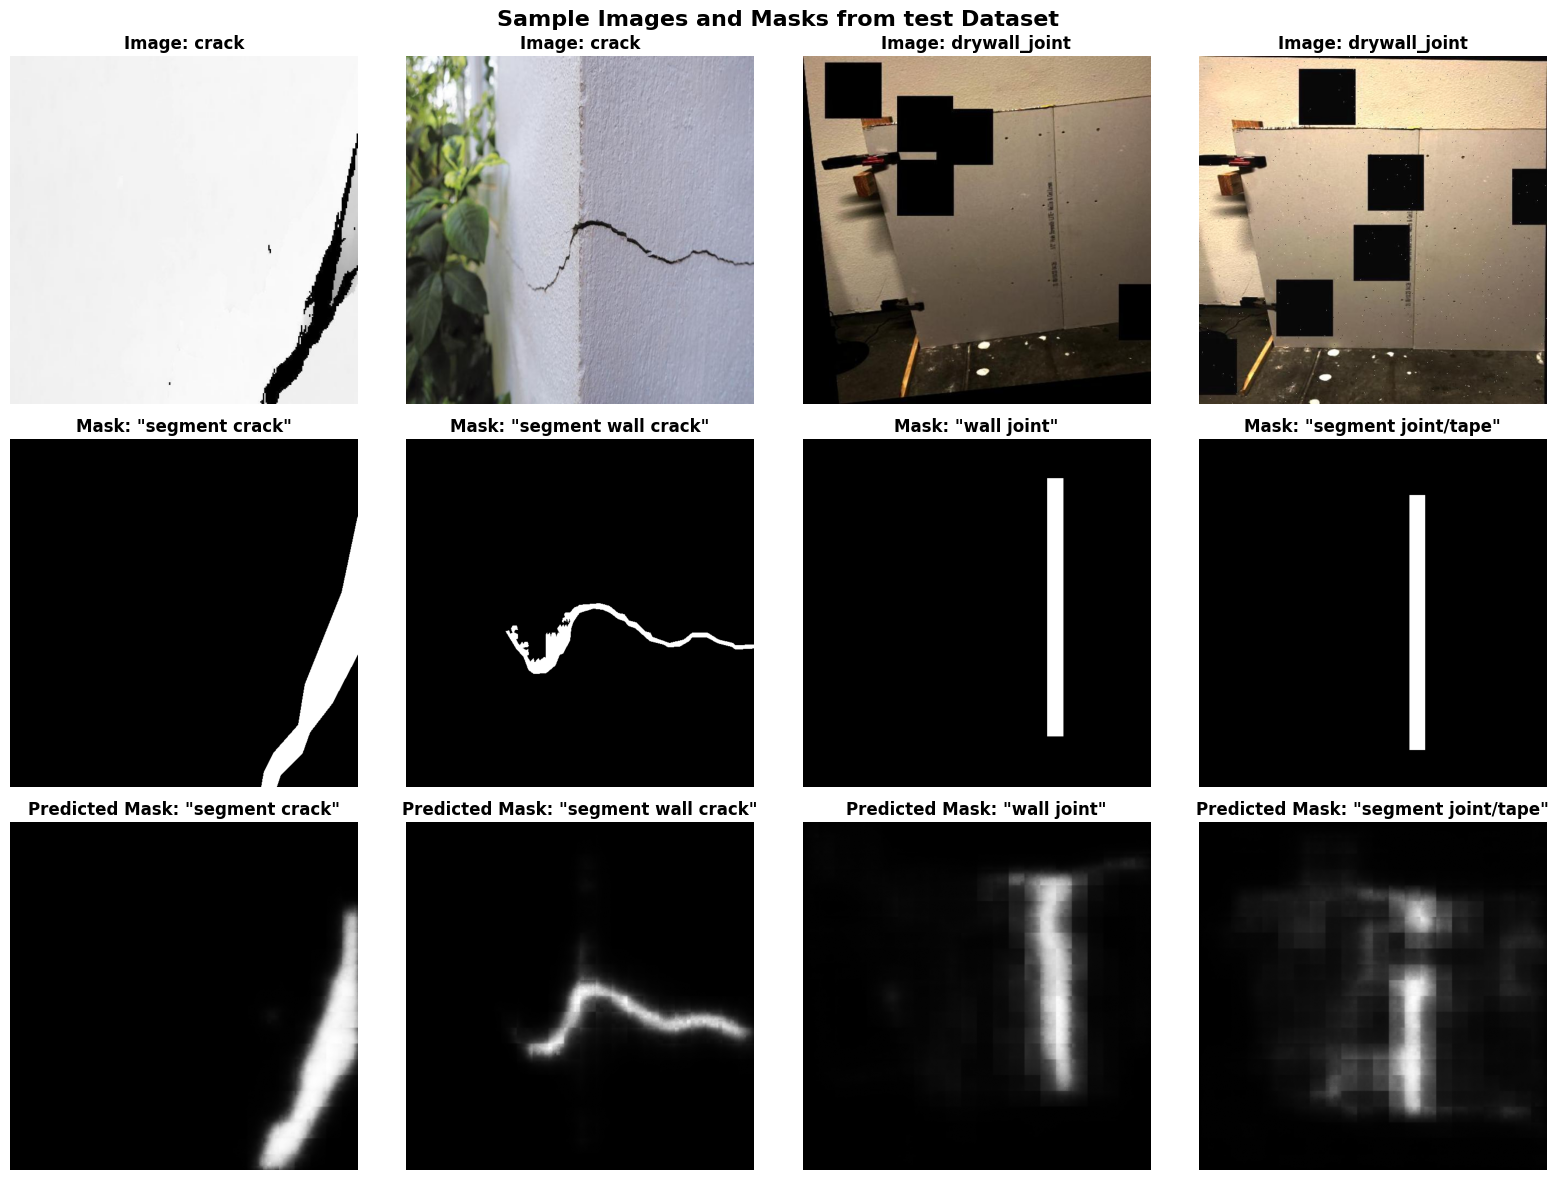

In [23]:
visualize_preds_and_masks(model, processor, val_dataset, val_labels, device, random_seed=102)

In [ ]:
preds_np = preds.cpu().numpy()

In [ ]:
print(np.sum(preds_np > 0.7))

In [ ]:
# calculate the footprint of the model
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

# print memory usage of model object
print(f"Memory usage during training: 1.59 GB")

# print disk space used by the saved model file
import os
model_file_path = "/Users/prashanthreddyduggirala/10x/notebooks/base_clipseg_drywall_model.pth"
model_file_size = os.path.getsize(model_file_path)
print(f"Model file size on disk: {model_file_size / (1024 **2):.2f} MB")

# inference time per image
import time
inference_times = []
num_inference_samples = 10
for i in range(num_inference_samples):
    sample = val_dataset[i]
    inputs = processor(
        text=sample['text_prompt'],
        images=sample['image'],
        return_tensors="pt"
    ).to(device)
    
    start_inference = time.time()
    with torch.no_grad():
        outputs = model(**inputs)
    end_inference = time.time()
    
    inference_times.append(end_inference - start_inference)

avg_inference_time = sum(inference_times) / num_inference_samples
print(f"Average inference time per image: {avg_inference_time * 1000:.2f} ms")  



Total parameters: 150747746
Trainable parameters: 150747746
Model size in memory: 0.00 MB
Model file size on disk: 583.88 MB
Average inference time per image: 241.04 ms
